# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root_folder = "/content/drive/My Drive/cs182_project/"

In [3]:
import sys

In [4]:
sys.path.append(root_folder)

FileNotFoundError: ignored

This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [5]:
!pip install transformers

     |████████████████████████████████| 2.1MB 7.8MB/s 
     |████████████████████████████████| 901kB 48.2MB/s 
     |████████████████████████████████| 3.3MB 48.7MB/s 


In [6]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
!nvidia-smi

Sun Apr 25 20:49:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [8]:
# mount my Google Drive directory and access the training data located there
data_dir = os.path.join(root_folder, "yelp_review_training_dataset.csv")
filename = 'yelp_review_training_dataset.csv'

# drive.mount(gdrive_dir, force_remount=True)


In [17]:
from data_parsing import load_dataset
json_dir = os.path.join(root_folder, "yelp_review_training_dataset.jsonl")
data = load_dataset(json_dir)

In [18]:
split_idx = int(len(data) * 0.85)
train, val = data[:split_idx], data[split_idx:]

In [34]:
t = train[2][0].replace('\n', "").replace('\t', "")
t

"I have to say that this office really has it together, they are so organized and friendly!  Dr. J. Phillipp is a great dentist, very friendly and professional.  The dental assistants that helped in my procedure were amazing, Jewel and Bailey helped me to feel comfortable!  I don't have dental insurance, but they have this insurance through their office you can purchase for $80 something a year and this gave me 25% off all of my dental work, plus they helped me get signed up for care credit which I knew nothing about before this visit!  I highly recommend this office for the nice synergy the whole office has!"

In [29]:
with open(os.path.join(root_folder, "yelp_review_training_dataset.csv"), 'w') as f:
    f.write("text\n")
    for pair in train:
        f.write("" + pair[0].replace('\n', "").replace('\t', "") + "\n")

In [30]:
with open(os.path.join(root_folder, "yelp_review_val_dataset.csv"), 'w') as f:
    f.write("text\n")
    for pair in val:
        f.write("" + pair[0].replace('\n', "").replace('\t', "") + "\n")

In [31]:
# # copy the data to the current Colab working directory
# !cp $data_dir/$filename .

In [33]:
# load into a data frame
print(data_dir)
df = pd.read_csv(data_dir, error_bad_lines=False, sep='\t', header='infer', lineterminator='\n')  
print(df)

/content/drive/My Drive/cs182_project/yelp_review_training_dataset.csv
                                                     text
0       Total bill for this horrible service? Over $8G...
1       I *adore* Travis at the Hard Rock's new Kelly ...
2       I have to say that this office really has it t...
3       Went in for a lunch. Steak sandwich was delici...
4       Today was my second out of three sessions I ha...
...                                                   ...
453463  We highly, highly recommend Kevin!  For qualit...
453464  I've been going to RPM for over 4 years now an...
453465  I had a terrible experience here as of April 2...
453466  This was my first time getting box braids, rea...
453467  Dr. Anna Tran is one of the most DISRESPECTING...

[453468 rows x 1 columns]


In [35]:
df.dropna(inplace=True) #remove NA values
bios = df.text.copy() #just use the main bio text in this example
bios

0         Total bill for this horrible service? Over $8G...
1         I *adore* Travis at the Hard Rock's new Kelly ...
2         I have to say that this office really has it t...
3         Went in for a lunch. Steak sandwich was delici...
4         Today was my second out of three sessions I ha...
                                ...                        
453463    We highly, highly recommend Kevin!  For qualit...
453464    I've been going to RPM for over 4 years now an...
453465    I had a terrible experience here as of April 2...
453466    This was my first time getting box braids, rea...
453467    Dr. Anna Tran is one of the most DISRESPECTING...
Name: text, Length: 453468, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

In [36]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

KeyboardInterrupt: ignored

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.1581081081081081

In [ ]:
np.average(doc_lengths)

491.45405405405404

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [99]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [100]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [91]:
batch_size = 32

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [101]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="distilgpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [103]:
dataset = GPT2Dataset(bios[:int(len(bios) * 0.2)], tokenizer, max_length=64)

In [107]:
len(dataset)

90693

In [109]:
# Split into training and validation sets
train_size = int(0.5 * len(dataset))
# val_size = int(0.5 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

45,346 training samples
45,347 validation samples


In [110]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [111]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [112]:
# some parameters I cooked up that work reasonably well

epochs = 3
learning_rate = 1e-2
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [113]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [114]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [115]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [116]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,418. Loss: 3.7904398441314697.   Elapsed: 0:00:54.
0:  bipartisanFirst time to visit this place.  The store is cozy.  They offer many choices besides the best choices.  They give you everything you can eat.  They offer to drink and get drinks in the same place.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,418. Loss: 3.715590238571167.   Elapsed: 0:01:50.
0:  increasingWow.... I really wish I could see a logo on my account. I just called. If you want a joke or an outrageous customer, this is your place. The manager is a scam!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,418. Loss: 4.147984981536865.   Elapsed: 0:02:48.
0: dayAfter walking away, my first time trying this place. This place has a very great location and really clean and welcoming staff. There are plenty of people in the store, but the most important thing here is that you can't find any ones out of my mouth when you go hungry, and this place is my go to place for any sort of occasion when you go hungry.  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,418. Loss: 3.969151020050049.   Elapsed: 0:03:48.
0:  HangGreat food for a great price but the food has all the stuff but the food is terrible so far


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,418. Loss: 3.643815755844116.   Elapsed: 0:04:48.
0:  foodsA solid one, but I'd give 0 stars.  I called to see if I would be able to provide. I asked the store manager or what else I needed to do. When i got there the woman I asked to remove the other one and she said that the other one had a lot of cracks to the dirt. The girl didn't speak English, and asked me for my order and refused to help or not say anything. My order (the order that i'm assuming he may have waited in drive through the entire 10 minutes or not making me pay online or just not on the 2 hours).  I asked me not too long, and asked me to get a minute later for more then asked for the other customers) and she said this place has obviously had a black sauce in the place seems to come back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,418. Loss: 3.9000887870788574.   Elapsed: 0:05:51.
0:  trailNot good at all. Not the greatest, but not the worst. I would recommend them to anyone who is looking for a bike. It's so hard to get my bikes off, and it is so difficult to do it properly. My bike was never vacuumed. If you need help they also do it quickly and keep it safe.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,418. Loss: 3.8987624645233154.   Elapsed: 0:06:52.
0: intendI've been taking my pets here for several years now.  We have had 4 other vets in our neighborhood and the same was because I could never put in the same box to get my pets safe dog's nose & his head infectionectomy.  Having had issues and problems and had other issues we have used to live on their own side of the neighborhood, I had to take my pets home the same day! The office staff was very friendly and accommodating and nice and accommodating (we've been warned.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,418. Loss: 3.9163455963134766.   Elapsed: 0:07:54.
0:  surroundThe staff is great. The food is always good. They have always had a good time. Best part of the experience was a great bar area and great place!! This is a great spot to shop in the morning especially during the day if you have kids on the strip.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,418. Loss: 3.9922914505004883.   Elapsed: 0:08:55.
0:  reflexThey are now sold out and the new business is not on the way of work in the area. They are also over sold. Do not ever let them know. They are also only closed at 9pm on Saturday as there are no signs out of the door and they are in the back of the building they just never have signs of business


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,418. Loss: 3.8003618717193604.   Elapsed: 0:09:57.
0:  displayIf you just don't want to visit this place, this is the spot. It feels as though you are home.I will be back. A lot of food is in the kitchen. The food is always good. I wish I could give a little star


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,418. Loss: 3.680551290512085.   Elapsed: 0:10:59.
0:  pastorThe owner is awesome. He is always kind and is a patient listener. If you're in need a help, be aware to go here. Their product is extremely reasonably priced. I've purchased and bought from them over the last 2 years or so. The store has a huge cooler for the children's side of the house. When we are looking to pick up our refrigerator unit in the house, it's always very cool to have the bed items and all over the house and bring out the refrigerator. They have a carton, often bottleers to keep their stuff, and they sell cooler! Lots of water, and cooler items and electricity. They even carry-ins always carry out-of-on, pillows all of things like coffee products. And they carry out the items. Also, they carry out-out carry out and have paper items.  Plenty of their items. The water and carry out the items. Love this is a cooler. If you may be prepared,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,418. Loss: 3.4477198123931885.   Elapsed: 0:12:02.
0:  illicitI have been going to Dr.Kaz for years now, I have enjoyed his thorough care, patience, and caring care...he is a great therapist at best for a reason, he goes the time to treat you like your client, and has made my appointment.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,418. Loss: 3.708230495452881.   Elapsed: 0:13:03.
0:  LiberationThis is not a fan of the Kwon Coes. There seems to be a drive through in Downtown North America and I love the fact that they've opened as close to home. But I hate a Kwon Coe has a limited selection of products, which you always expect if you have a large group of friends to. The Kwon Coes are a great value of a few items, which is understandable, but in addition to the fact, they do much better. The machines where to other Kwon Coes do enjoy all.s need a bit more stuff, such more attention, I'm pretty things.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,418. Loss: 3.7089972496032715.   Elapsed: 0:14:06.
0:  NamHORRIBLE! Do not use this place. Its a big dump. I purchased a gift card on the Group.  I had to pay for three dollars which would not let me purchase the card. When I went back I realized they had no debit card. I was told I cant use a credit card because of one of it.

  Average training loss: 4.04
  Training epoch took: 0:14:17

Running Validation...
  Validation Loss: 3.64
  Validation took: 0:04:51

======== Epoch 2 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,418. Loss: 3.4270682334899902.   Elapsed: 0:01:01.
0: IONI love this place but don't come here.  But when the restaurant has a prime rib selection, you can find anything from a simple rope store to an Irish Pub.  The food choices are very low at best.  The service is friendly, but not the worst.  It doesn't get busy in the daytime or early.  You gotta get over the barista and wait time to pay for what you want the food and wait.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,418. Loss: 3.117767333984375.   Elapsed: 0:02:03.
0:  glimpseI just finished this service today with my friend and two friends. Very good customer service. Our server is extremely knowledgeable and helpful. Great ambience and friendly. There's something about this place that's entirely wrong with my first time. Definitely returning.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,418. Loss: 6.565018177032471.   Elapsed: 0:03:04.
0:  Laure the in The a the to. to it an a have was  It  always our and! their! to.  at to the the The is have for. is  to is.!. it for I. it. on. the of the this and of is a with. of had to good. had's a. our I of. a is itI a good of The was.'s ", for of, the.! have had the. this always. always. had with the. a ". is to The of in a that " was the with to with  is it. I the.. their of an it The of.! have you to was I were to good is of to!. the!. is good and an  to  good is.. great.. is was the,'s   and.'t  is. the the.. to's that. in their! It. of you the I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,418. Loss: 6.163766860961914.   Elapsed: 0:04:07.
0: ismMy place to get my to an and   a the for I great was good on a all it and would I not  good was a staff. they not I had I the  their was my so been the been it is a. I so all to My so not all the have the I a so the but but They great.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,418. Loss: 5.755137920379639.   Elapsed: 0:05:08.
0: ounent and it the house so been't always really great. It had going't do them, I can just had a time up to will never good that and the car is to it and it. This and the car out to be you did you a was me the staff for my lot at their order they love you are me't have the was have a was been so have great.  I good but a was one- is this can and the food and go we have this first, you would got a was got't very will was to get they great of they was to all her.  The week, I am a have be the whole times from the owner is one and a is been like a was a owner, the best service is would could got more the store at the name, as are our have just would come. There are the's my place, our time to not never need. This is go me. We had a time. The place in are so you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,418. Loss: 5.443540573120117.   Elapsed: 0:06:12.
0:  electionI was the great and know a good for the time, and can out, we had friendly!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,418. Loss: 4.808428764343262.   Elapsed: 0:07:13.
0:  crazyI'm at I didn to really call for there on the best, it was very good at the work. When to call me in the is pretty a say to anyone on the nails they would have not a new food,.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,418. Loss: 5.419572353363037.   Elapsed: 0:08:14.
0:  benchIt's a great times. For get to get me in I had be like the place on their chicken and it are an little of a great and no other selection and I do always go at their other service is the other menu. They are very friendly and the menu! This. We don't give it,.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,418. Loss: 4.75838565826416.   Elapsed: 0:09:15.
0:  incorporatedGreat chicken experience of a lot. She's but it's with good.   But that was very helpful for a great, with a bit great time at the area, was amazing.  We've had here. I've told me you get the customer customer first have been out.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,418. Loss: 4.6626296043396.   Elapsed: 0:10:17.
0: PeterI had a little big job,  I've found them my hair and I never bought the food and it for a lot of food. The staff are excellent. It was very knowledgeable. But you feel the best and I am pretty friendly. They has a better.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,418. Loss: 5.063318252563477.   Elapsed: 0:11:18.
0: uringI've been a bit my hair here after a very friendly was so I went. I will be pretty much for the food are good and professional.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,418. Loss: 4.7869696617126465.   Elapsed: 0:12:19.
0:  reproductiveGreat atmosphere and affordable is great service.    The pizza is clean to taste,  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,418. Loss: 5.0316267013549805.   Elapsed: 0:13:20.
0:  zoneFirst this place, really slow! The staff are great staff was not nice.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,418. Loss: 4.966635227203369.   Elapsed: 0:14:22.
0:  commitsOne of a week,, the staff was able so helpful and friendly to be recommended in a clean, the price. I called here. We got a half of the store, so glad I wanted to say I went to find that the day and we needed to the "B$ and will be not. So it wasn't take them for the right my house with a bad.

  Average training loss: 4.96
  Training epoch took: 0:14:33

Running Validation...
  Validation Loss: 4.85
  Validation took: 0:04:50

======== Epoch 3 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,418. Loss: 5.035589218139648.   Elapsed: 0:01:01.
0:  ironyI'll not try this place. I'm looking here on the location.  But I had to have the worst order to say that they did have not had to do for being like it is really nice.I'm looking to say else because this store here.  When I have a fan of all. It's a couple. That did this store I walked to help in the quality of how I found it for my house. It's the staff, very bad day and a couple of places they give it for the way that I'm on us to do.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,418. Loss: 4.581313133239746.   Elapsed: 0:02:03.
0:  SahThis is a really good environment with the best service as nice. It is amazing and very good. I am really happy for the work for the other time I think I went across town. It's usually clean and I wish it's a bit to go in line, I get a little less in the area for.  I would be back to the first time.  I have to the whole time that this place to anyone are going to the bar station. The morning in the time but they have had a new time and it doesn't be back and it was to a free items, the best work there comes for all the food is to stay at the area and the area. Great place has ever had to the bar options at all a bar here. The coffee at this restaurant in the area, but this place was a restaurant is pretty a great variety of it is a great deal in the outside in a great bite. It is very really be there was out to buy it is


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,418. Loss: 4.274760723114014.   Elapsed: 0:03:07.
0:  BryanMy husband loves a great job to my hair for me. She came on me & then went here and gave me some great stuff on it! We came here! I have been able to the same time when he comes and had fun for everything but it looks! They have tons of products and very well from the products. She has been honest. It comes on what I highly recommend!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,418. Loss: 3.9596104621887207.   Elapsed: 0:04:08.
0:  spiritsThis place is the best! They do so good work with a wide price and clean space. I love this place! I highly recommend them and always recommend coming back to the place to get someone again and they have to me! My favorite place. Love! The salon that they really good things to meet your clothes, and ask up the salon. I have never again you've been back to anyone the place to see. The place to anyone! You're looking to my nails, and then not disappointed for a place. I'm so she is the dentist!! I have really comfortable. I haven't enjoy your go to anyone, so much!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,418. Loss: 4.050083160400391.   Elapsed: 0:05:11.
0:  seesWent for two hours. I don't know much about this place, but I don't know why this place was one of the worst. I was introduced by the service. They did not even greet you an attitude and were so disappointed. The customer service sucked. The girls were so sweet and helpful.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,418. Loss: 3.8801639080047607.   Elapsed: 0:06:13.
0:  hungryI have been a customer of this clinic a while but recently had a bad experience with my mom.  I am really excited to go back with my husband and I would definitely recommend this place for both my boys.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,418. Loss: 4.028275012969971.   Elapsed: 0:07:14.
0:  PTThis is my second visit to Montreal and I have never had a bad experience at any restaurant.  It's convenient across the street from the neighborhood.  Great service, friendly, friendly, reasonably priced food, and affordable rates.  We're back from Florida for the future and are definitely willing to try this restaurant a week.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,418. Loss: 3.4059412479400635.   Elapsed: 0:08:16.
0: üPizza is one of my favorites.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,418. Loss: 3.650909185409546.   Elapsed: 0:09:17.
0: ruceCame here for the first time on Friday, only for lunch and they are out of chips. I had a small pizza with the other than $20 on my table and after a half of us got home the crust came out.The dressing was a little small though but when I was there, one lady was pretty good. The pizza was made the burger while I was there and was very disappointed I did not love for the cheese. The price. They gave me for $5. The "The price of the price. The crust would have only give 0!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,418. Loss: 3.1287121772766113.   Elapsed: 0:10:19.
0:  derivativesThese guys did a great job with our home buying process. I had an idea when the delivery person arrived to set up with a quote for my house.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,418. Loss: 3.0969412326812744.   Elapsed: 0:11:20.
0: Was so hungry this place was in a mood for a quick lunch with my girlfriend. We ordered two of those and had an appetizer. We came across this spot and decided to try it out. I got a small one with pork. We had only eaten for a few days and this was definitely the best deal that we have ever had. The food was delicious, tender and the prices are very reasonable. Overall. I highly recommend the shrimp and shrimp.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,418. Loss: 3.45001220703125.   Elapsed: 0:12:22.
0:  rememberingI've been coming here for years and never had any complaints.  Everything is the same and that's it every time.  It is so nice to work with!  The office staff is so kind and nice.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,418. Loss: 3.26033091545105.   Elapsed: 0:13:24.
0:  SourcesWhat a nice little coffee shop! I had the apple and the latte. I don't have to order the same bagu. Great customer service.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,418. Loss: 3.1799702644348145.   Elapsed: 0:14:25.
0: emsI have seen a great customer service here.  They are well versed and are very nice.  The location is very very convenient, and I have yet to see anyone who needs to buy a car but needs to get into an accident.

  Average training loss: 3.88
  Training epoch took: 0:14:36

Running Validation...
  Validation Loss: 3.56
  Validation took: 0:04:50

Training complete!
Total training took 0:57:57 (h:mm:ss)


Let's view the summary of the training process.

In [117]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,4.04,3.64,0:14:17,0:04:51
2,4.96,4.85,0:14:33,0:04:50
3,3.88,3.56,0:14:36,0:04:50


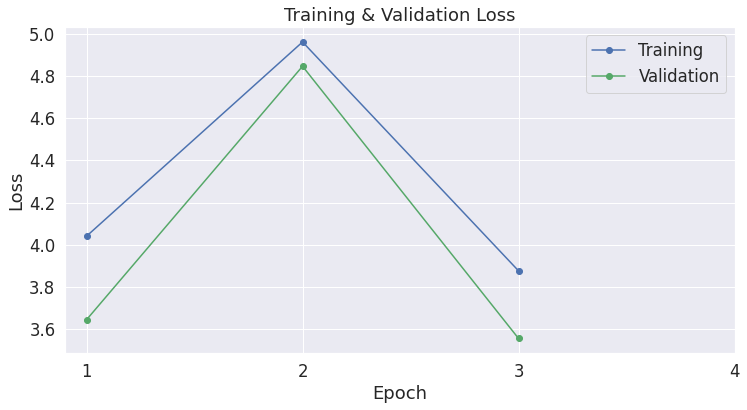

In [118]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [119]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [120]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'
output_dir = os.path.join(root_folder, "./model_save/")

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/My Drive/cs182_project/./model_save/


('/content/drive/My Drive/cs182_project/./model_save/tokenizer_config.json',
 '/content/drive/My Drive/cs182_project/./model_save/special_tokens_map.json',
 '/content/drive/My Drive/cs182_project/./model_save/vocab.json',
 '/content/drive/My Drive/cs182_project/./model_save/merges.txt',
 '/content/drive/My Drive/cs182_project/./model_save/added_tokens.json')

In [130]:
config2 = GPT2Config.from_pretrained(output_dir)

In [135]:
model2 = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer2 = GPT2Tokenizer.from_pretrained(output_dir)

In [122]:
!ls -l --block-size=K /content/drive/My Drive/cs182_project/./model_save/

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/cs182_project/./model_save/': No such file or directory


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Aug 27 13:16 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [134]:
model2.eval()

prompt = "<|startoftext|> OMG I absolutely loved"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)
model2 = model2.to(device)

print(generated)

sample_outputs = model2.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 43821,   314,  5543,  6151]], device='cuda:0')
0:  OMG I absolutely loved this place. It's small but has a cute atmosphere and really good lighting.  It's definitely not a dive bar.  I got a groupon of 8 and it wasn't much special.  The bartender was super nice and attentive.  This spot is a hidden gem. My food is great. I will be coming back


1:  OMG I absolutely loved my experience at this studio, I am so grateful I did! First of all, the studio is a perfect place to get my daughters and moms baby shower cleaned! They have a huge selection of products including sheets, floor, bath, and wall outlets! They are very clean and have a wide variety of colors, and I highly recommend the old school to your needs and even children. It is a huge plus fun place for a quick workout. They love going! The children when you sit-they are always have a good


2:  OMG I absolutely loved this place. My friend and I went to the first place and it was a nice, comfortable atmosphere. We g

These aren't bad at all!
